# Unsupervised learning with Autoencoder

Some piece of codes taken from https://github.com/kevinzakka/vae-pytorch

<img src='Autoencoder_structure.png'>

Description given by [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

In [3]:
#where your MNIST dataset is stored:
data_dir = '~/data'
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Helper Functions

In [49]:
def to_img(x):
    x = x.data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model, conv=False):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    if not conv:
        data = data.view([-1, 784])
    data.requires_grad = False
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()
    
def plot_denoising(model, conv=False, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data += noise * torch.randn(data.size())
    if not conv:
        data = data.view([-1, 784])
    data.requires_grad = False
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [92]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [11]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension? What is the learning rate?

In [7]:
loss_fn = torch.nn.MSELoss()

def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            
            data = data.view([-1, 784])
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [12]:
train_model(model, loss_fn, data_loader=train_loader, epochs=15, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.124530
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.059394
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.044904
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.037064
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.032616
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.030234
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.027685
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.024228
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.024443
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.021918
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.021669
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.021464
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.020646
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.020013
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.019125
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.018831
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.018959
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.018386
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.019125
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.017026
Train Epoch: 4 [0/60

In [28]:
plot_reconstructions(model)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 1, 3, 3], but got 2-dimensional input of size [10, 784] instead

If you remove the non-linearity, what are you doing?

## Stacked Auto-Encoder

In [14]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, encoding_dim), 
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, input_dim),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [16]:
model.encoder

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU(inplace)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU(inplace)
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU(inplace)
)

In [17]:
model.decoder

Sequential(
  (0): Linear(in_features=32, out_features=64, bias=True)
  (1): ReLU(inplace)
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): ReLU(inplace)
  (4): Linear(in_features=128, out_features=784, bias=True)
)

In [18]:
train_model(model, loss_fn,data_loader=train_loader,epochs=15,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.118934
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.064565
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.058141
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.048462
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.040995
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.038087
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.035761
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.033744
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.031226
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.030151
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.029099
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.029231
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.029347
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.027154
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.028200
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.026620
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.027320
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.026498
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.025623
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.026747
Train Epoch: 4 [0/60

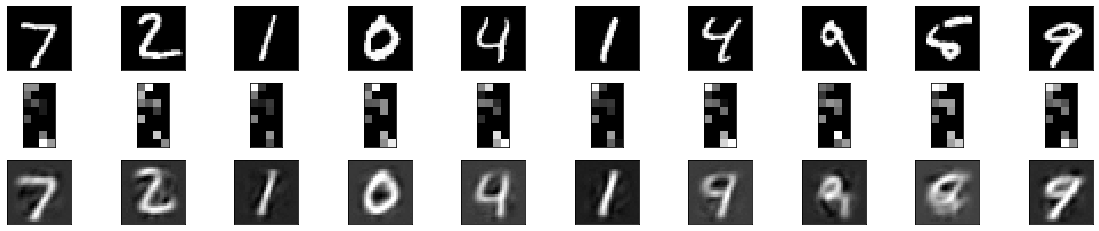

In [19]:
plot_reconstructions(model)

# Exercise

- Change the loss to a BCE loss. 

- Implement weight sharing.

Hint, a rapid google search gives:

https://discuss.pytorch.org/t/how-to-create-and-train-a-tied-autoencoder/2585

## Convolutional Auto-Encoder

Deconvolution are creating checkboard artefacts see [Odena et al.](https://distill.pub/2016/deconv-checkerboard/)

In [20]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
model = ConvolutionalAutoEncoder()
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

Why is 

`train_model(model,loss_fn,data_loader=train_loader,epochs=15,optimizer=optimizer)` 

not working? Make the necessary modification.

In [24]:
def train_convmodel(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [25]:
train_convmodel(model, loss_fn,data_loader=train_loader,epochs=15,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.559958
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.476554
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.377910
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.280438
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.261373
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.256025
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.255560
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.248954
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.248433
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.245972
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.234251
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.230266
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.222979
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.220006
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.205975
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.218480
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.208801
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.208428
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.201475
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.203555
Train Epoch: 4 [0/60

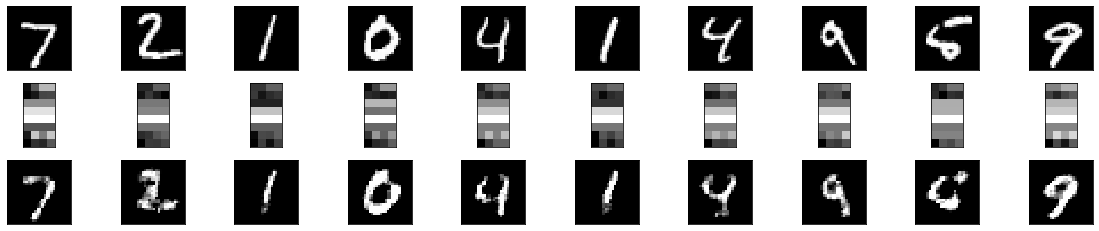

In [33]:
plot_reconstructions(model, conv=True)

# Exercise

Implement a denoising AE:

![denoising AE](denoisingAE.png)


Use previous code and with minimal modifications, transform your AE in a denoising AE.

Why is this not working well? Try to improve the denoising performance.

You should obtain results like this:

![res_denoise](denoiseAE.png)

In [47]:
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            noisy_data = data + noise*torch.randn(data.size())
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [39]:
model = ConvolutionalAutoEncoder()
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [48]:
train_denoiser(model, loss_fn,data_loader=train_loader,epochs=3,optimizer=optimizer, noise=0.1)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.185480
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.184888
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.188105
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.182622
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.185535
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.187566
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.181507
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.183160
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.180842
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.187759
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.180472
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.175888
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.178983
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.179447
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.176335


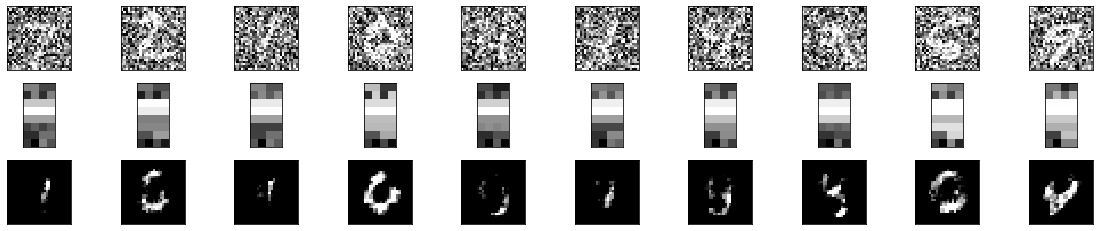

In [52]:
plot_denoising(model, conv=True, noise=0.7)

# A nice visualization

Loss :  7.117130279541016
Loss :  3.947838544845581
Loss :  0.9530898928642273
Loss :  0.11800253391265869
Loss :  0.0468025803565979
Loss :  0.02770370803773403
Loss :  0.01955539919435978
Loss :  0.017196185886859894
Loss :  0.012561624869704247
Loss :  0.011456336826086044
Loss :  0.009240181185305119
Loss :  0.008311711251735687
Loss :  0.007268214598298073
Loss :  0.006520978175103664
Loss :  0.0061210524290800095
Loss :  0.0053995768539607525
Loss :  0.00543985515832901
Loss :  0.004725461360067129
Loss :  0.004917759448289871
Loss :  0.004290016368031502


Text(0.5, 1.0, 'Vector field $\\hatx - x$ for a denoising encoder')

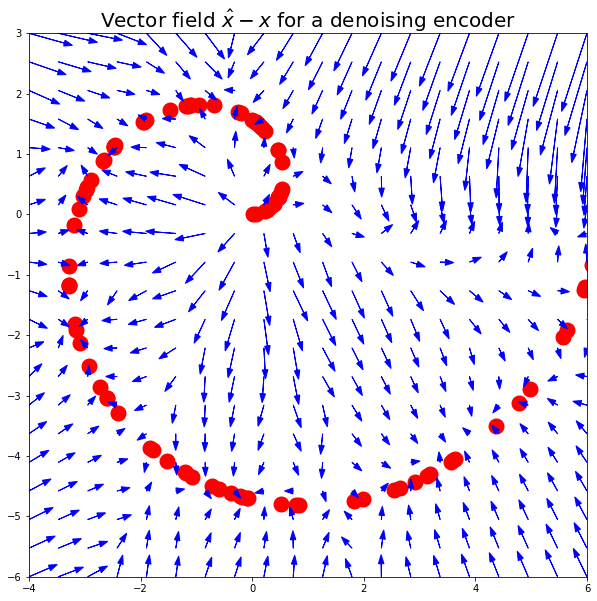

In [35]:
from itertools import product

plt.figure(figsize=(10,10))

n_batches = 100
batch_size = 100
thetas = np.random.uniform(0, 2*np.pi, batch_size*n_batches)
points = [[np.cos(theta)*theta, np.sin(theta)*theta] for theta in thetas]
dataset = torch.Tensor(points).view(n_batches,batch_size,-1)
for point in dataset[0]:
    plt.scatter(point[0], point[1], lw=10, color='red')
dataset += 0.3*torch.randn(dataset.size())

    
class SimpleAutoEncoder(nn.Module):
    def __init__(self):
        super(SimpleAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2,10),
            nn.ReLU(True),
            nn.Linear(10,20),
        )
        self.decoder = nn.Sequential(
            nn.Linear(20,10),
            nn.ReLU(True),
            nn.Linear(10,2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = SimpleAutoEncoder()
crit = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.001)

def train(model, dataset, epochs=10):
    for epoch in range(epochs):
        for batch_idx, data in enumerate(dataset):
            opt.zero_grad()
            out = model(data)
            loss = crit(out,data)
            loss.backward()
            opt.step()
            if batch_idx%50 == 0:
                print('Loss : ', loss.item())
                
train(model, dataset)

x_arr = torch.linspace(-4,6,20)
y_arr = torch.linspace(-6,3,20)
new_x_arr = []
new_y_arr = []
for x, y in product(x_arr, y_arr):
    point = torch.Tensor([x,y])
    new_x, new_y = model(point).data.numpy()
    new_x_arr.append(new_x)
    new_y_arr.append(new_y)
    plt.arrow(x, y, new_x-x, new_y-y, head_width=0.1, color='blue')
    
plt.xlim([-4,6])
plt.ylim([-6,3])
plt.title('Vector field $\hatx - x$ for a denoising encoder', fontsize=20)